In [11]:
import pandas as pd
import os

df = pd.read_csv('../data/curated/final_merged_data_sa2.csv')

selected_columns = ['SA2'] + [col for col in df.columns if 'Dec' in col and 'median' in col]

df_dec_median = df[selected_columns]

for year in [2024, 2025, 2026]:
    new_column = f'Dec {year} median'
    df_dec_median[new_column] = -1

output_path = '../data/curated/regression_model/final_merged_data_dec_sa2.csv'
# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_dec_median.to_csv(output_path, index=False)

print(f"Processed data saved to {output_path}")

Processed data saved to ../data/curated/regression_model/final_merged_data_dec_sa2.csv


/var/folders/kt/yhd0mp_91gn1qrk_l__r080r0000gn/T/ipykernel_26524/3196972103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec_median[new_column] = -1
/var/folders/kt/yhd0mp_91gn1qrk_l__r080r0000gn/T/ipykernel_26524/3196972103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dec_median[new_column] = -1
/var/folders/kt/yhd0mp_91gn1qrk_l__r080r0000gn/T/ipykernel_26524/3196972103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [12]:
import pandas as pd

input_file = '../data/curated/regression_model/final_merged_data_dec_sa2.csv'
df = pd.read_csv(input_file)

median_columns = [col for col in df.columns if 'median' in col]

df_long = pd.melt(df, id_vars=['SA2'], value_vars=median_columns, var_name='year', value_name='median')

df_long['year'] = df_long['year'].str.extract(r'(\d{4})')  
df_long = df_long.rename(columns={'SA2': 'region'})  

print("Transformed DataFrame:")
print(df_long.head())

output_file = '../data/curated/regression_model/final_merged_dec_sa2_long.csv'
df_long.to_csv(output_file, index=False)

print(f"Transformed data saved to {output_file}")

Transformed DataFrame:
                  region  year  median
0  Bright - Mount Beauty  1999   120.0
1             Myrtleford  1999   120.0
2           Yackandandah  1999   120.0
3                  Avoca  1999   105.0
4               Beaufort  1999   105.0
Transformed data saved to ../data/curated/regression_model/final_merged_dec_sa2_long.csv


In [13]:
import pandas as pd
import ast

df_main = pd.read_csv('../data/curated/regression_model/final_merged_dec_sa2_long.csv')

df_dict = pd.read_csv('../data/raw/region_data/cleaned_range_data_with_projection.csv')

dict_columns = ['population', 'population_density', 'percentage_working_population',
                'internal_arrivals', 'nBusiness', 'nHouses', 'nTownhouses', 'nApartments',
                'nDwellings', 'median_income', 'nJob', 'percentage_year_12', 'nEmployed',
                'nUnEmployed', 'nRented', 'nHomeless']

expanded_df = pd.DataFrame()

for index, row in df_dict.iterrows():
    region_name = row['region_name']
    
    region_expanded_data = pd.DataFrame()
    
    years = None
    
    for col in dict_columns:
        if pd.notna(row[col]):  
            try:
                data_dict = ast.literal_eval(row[col])
                
                if years is None:
                    years = list(data_dict.keys())  
                
                region_expanded_data[col] = pd.Series(data_dict)
            except (ValueError, SyntaxError):
                print(f"Skipping row {index} for column '{col}' due to parse error.")
        else:
            region_expanded_data[col] = [None] * len(years)
    
    region_expanded_data['year'] = years
    region_expanded_data['region'] = region_name
    
    expanded_df = pd.concat([expanded_df, region_expanded_data], ignore_index=True)

expanded_df['year'] = expanded_df['year'].astype(str)
expanded_df['region'] = expanded_df['region'].str.replace(" ", "")

df_main['year'] = df_main['year'].astype(str)
df_main['region'] = df_main['region'].str.replace(" ", "")

df_merged = pd.merge(expanded_df, df_main, on=['region', 'year'], how='left')

df_filled = df_merged.fillna(0)
df_filtered = df_filled[df_filled['median'] != 0]


output_path = '../data/curated/regression_model/final_merged_expanded_long.csv'
df_filtered.to_csv(output_path, index=False)

print(f"Merged data saved to {output_path}")

Skipping row 2 for column 'nHomeless' due to parse error.
Skipping row 4 for column 'nTownhouses' due to parse error.
Skipping row 4 for column 'nApartments' due to parse error.
Skipping row 4 for column 'nHomeless' due to parse error.
Skipping row 6 for column 'median_income' due to parse error.
Skipping row 7 for column 'median_income' due to parse error.
Skipping row 8 for column 'median_income' due to parse error.
Skipping row 9 for column 'median_income' due to parse error.
Skipping row 10 for column 'nApartments' due to parse error.
Skipping row 13 for column 'nTownhouses' due to parse error.
Skipping row 14 for column 'nApartments' due to parse error.
Skipping row 18 for column 'nApartments' due to parse error.
Skipping row 24 for column 'nTownhouses' due to parse error.
Skipping row 24 for column 'nApartments' due to parse error.
Skipping row 25 for column 'nApartments' due to parse error.
Skipping row 27 for column 'nApartments' due to parse error.
Skipping row 35 for column '

# Linear Regression

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

file_path = '../data/curated/regression_model/final_merged_expanded_long.csv'
data = pd.read_csv(file_path)

train_data = data[data['median'] != -1]
test_data = data[data['median'] == -1]

train_regions = train_data[['region', 'year']].reset_index(drop=True)
test_regions = test_data[['region', 'year']].reset_index(drop=True)

train_data_encoded = pd.get_dummies(train_data, columns=['region'], drop_first=True)
test_data_encoded = pd.get_dummies(test_data, columns=['region'], drop_first=True)

train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='inner', axis=1, fill_value=0)

X = train_data_encoded.drop(['median', 'year'], axis=1) 
y = train_data_encoded['median']  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_data_encoded.drop(['median', 'year'], axis=1)
y_test = test_data_encoded['median']  

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train MSE: {train_mse}")
print(f"Train R2 Score: {train_r2}")

y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")

y_test_pred = model.predict(X_test)

test_regions['median_predicted'] = y_test_pred
output_path = '../data/results/lr_predictions.csv'
# Ensure the directory exists before saving the file
os.makedirs(os.path.dirname(output_path), exist_ok=True)
test_regions.to_csv(output_path, index=False)
print(f"Predicted test set saved to {output_path}")

actual_2023 = train_data[train_data['year'] == 2023][['region', 'median']].rename(columns={'median': 'median_2023'})

predicted_2026 = test_regions[test_regions['year'] == 2026][['region', 'median_predicted']].rename(columns={'median_predicted': 'median_predictions_2026'})

common_regions = set(actual_2023['region']).intersection(set(predicted_2026['region']))
print(f"Number of common regions: {len(common_regions)}")

growth_df = pd.merge(actual_2023, predicted_2026, on='region', how='outer')

growth_df['Growth_Rate (%)'] = ((growth_df['median_predictions_2026'] - growth_df['median_2023']) / growth_df['median_2023']) * 100
growth_df['Growth_Rate (%)'].fillna(0, inplace=True)

growth_output_path = '../data/results/growth_rate_lr.csv'

growth_df.to_csv(growth_output_path, index=False)

print(f"Growth rate between 2023 and 2026 saved to {growth_output_path}")

Train MSE: 971.2522848670025
Train R2 Score: 0.9003776324552918
Validation MSE: 1095.7224374592831
Validation R2 Score: 0.8864721878673527
Predicted test set saved to ../data/results/lr_predictions.csv
Number of common regions: 447
Growth rate between 2023 and 2026 saved to ../data/results/growth_rate_lr.csv


# Random Forest

Train MSE: 76.6877501033905
Train R2 Score: 0.9921340568809855
Validation MSE: 565.9523815387312
Validation R2 Score: 0.9413616683835216
Top 10 Feature Importances:
               Feature  Importance
11  percentage_year_12    0.413791
9        median_income    0.224492
3    internal_arrivals    0.116976
4            nBusiness    0.084137
14             nRented    0.018839
1   population_density    0.014793
13         nUnEmployed    0.013712
15           nHomeless    0.012799
8           nDwellings    0.012024
10                nJob    0.011087


/var/folders/kt/yhd0mp_91gn1qrk_l__r080r0000gn/T/ipykernel_26524/3504307649.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['median_predictions'] = test_predictions


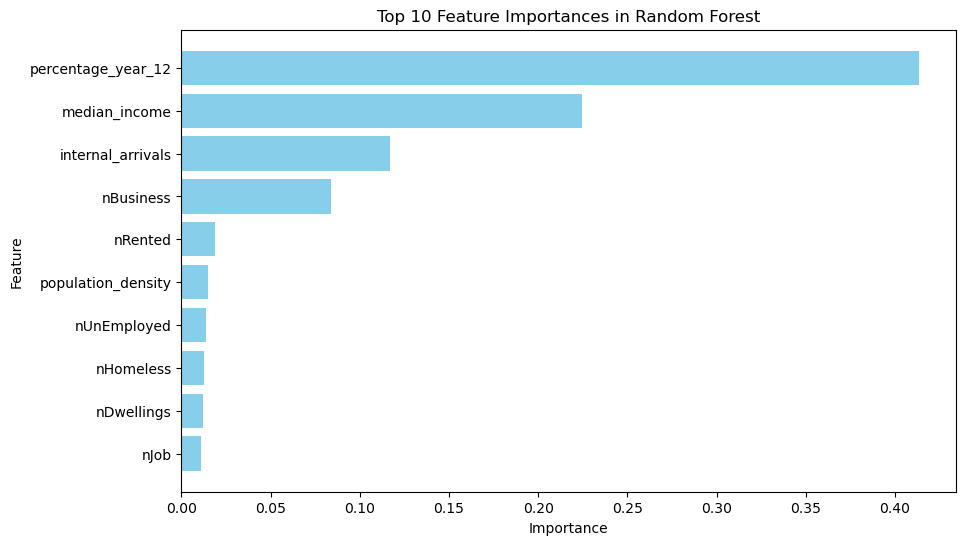

Number of common regions: 447
Merged DataFrame Sample:
                 region  median_2023  median_predictions_2026  Growth_Rate (%)
0             Alfredton        410.0                   515.24        25.668293
1              Ballarat        410.0                   496.30        21.048780
2             Buninyong        410.0                   507.02        23.663415
3             Delacombe        410.0                   441.02         7.565854
4  Wendouree-MinersRest        410.0                   416.11         1.490244
Growth rate between 2023 and 2026 saved to ../data/results/growth_rate_rf.csv


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('../data/curated/regression_model/final_merged_expanded_long.csv')

df['median'] = df['median'].replace(-1, np.nan)

train_data = df[df['median'].notna()]
test_data = df[df['median'].isna()]

X = train_data.drop(columns=['median', 'year'])  
y = train_data['median']  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_data.drop(columns=['median', 'year'])  
y_test = test_data['median']

X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
X_val, X_test = X_val.align(X_test, join='left', axis=1, fill_value=0)

model = RandomForestRegressor(random_state=42)

model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

print(f"Train MSE: {train_mse}")
print(f"Train R2 Score: {train_r2}")

val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

print(f"Validation MSE: {val_mse}")
print(f"Validation R2 Score: {val_r2}")

test_predictions = model.predict(X_test)

test_data['median_predictions'] = test_predictions

test_data.to_csv('../data/results/rf_predictions.csv', index=False)

feature_importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importances:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances in Random Forest')
plt.gca().invert_yaxis() 
plt.show()

actual_2023 = train_data[train_data['year'] == 2023][['region', 'median']].rename(columns={'median': 'median_2023'})

predicted_2026 = test_data[test_data['year'] == 2026][['region', 'median_predictions']].rename(columns={'median_predictions': 'median_predictions_2026'})

common_regions = set(actual_2023['region']).intersection(set(predicted_2026['region']))
print(f"Number of common regions: {len(common_regions)}")

growth_df = pd.merge(actual_2023, predicted_2026, on='region', how='outer')

growth_df['Growth_Rate (%)'] = ((growth_df['median_predictions_2026'] - growth_df['median_2023']) / growth_df['median_2023']) * 100

growth_df['Growth_Rate (%)'].fillna(0, inplace=True)

print("Merged DataFrame Sample:")
print(growth_df.head())

growth_output_path = '../data/results/growth_rate_rf.csv'
growth_df.to_csv(growth_output_path, index=False)

print(f"Growth rate between 2023 and 2026 saved to {growth_output_path}")